In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Pre-experiment: growth with pH control

In [2]:
growth_data = (pd.read_csv('../data/Exp_data/GrowthpHcontrol_pre.csv')).dropna()
growth_data = growth_data.drop(['Time'],axis=1)

In [3]:
timepts, samples, od600 = [],[],[]
for i in range(len(growth_data.columns)):
    for j in range(len(growth_data.index)):
        samples.append( growth_data.columns[i].split('_')[0].strip() )
        timepts.append( int(j) )
        od600.append( growth_data.iloc[j][i] )
temp_pd = pd.DataFrame(zip(timepts, samples, od600),columns=['Time','Sample','OD600'])

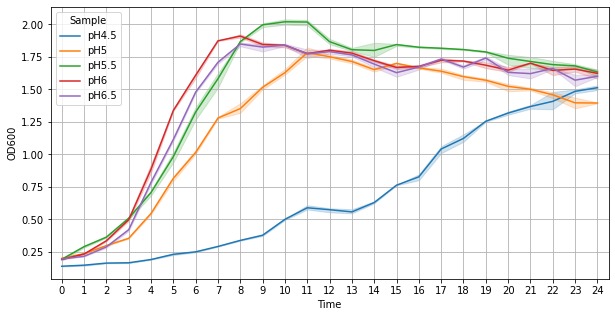

In [4]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x="Time", y="OD600",
             hue="Sample", 
             data=temp_pd,ax=ax)
ax.set_xticks(np.arange(0,25));
ax.set_xlim([-0.5,24.5])
ax.grid()

# Process proteomics dataset

In [4]:
def save_clean_fasta( in_path, out_path ):
    temp_records = SeqIO.parse( in_path , "fasta")
    new_records = []
    for seq_record in temp_records:
        ID = str(seq_record.id).split('|')[1].strip()
        seq = str(seq_record.seq)
        new_records.append( SeqRecord(Seq(seq), id = ID, name="",description="") )
    SeqIO.write(new_records, out_path ,"fasta")
    print( len(new_records) )

In [5]:
save_clean_fasta( '../data/Proteomics/uniprotkb_taxonomy_id_220668.fasta', '../data/Proteomics/wcfs1_prot.fasta' )

3088


In [2]:
proA, proB = pd.read_excel('../data/Proteomics/Proteomics_A.xlsx'), pd.read_excel('../data/Proteomics/Proteomics_B.xlsx') 
proA = proA[ ['Accession'] + list(proA.columns[-12:])].fillna(0)
proB = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
proA = proA.rename(columns={"Accession": "ID"})
proB = proB.rename(columns={"Accession": "ID"})

In [3]:
proAB = proA.merge(proB, left_on=['ID'], right_on= ['ID'],how='inner')
# proAB.to_csv('../data/Proteomics/Proteomics_AB.csv',index=None)

In [5]:
X = (proAB.iloc[:,1:].values).T
Xstd = StandardScaler().fit_transform(X)
pca_transform = PCA(n_components=2)
X_pca = pca_transform.fit_transform( Xstd )

In [6]:
print(pca_transform.explained_variance_ratio_)

[0.52181875 0.19651578]


In [7]:
samples = list( proAB.columns[1:] )
X_pca_pd = pd.DataFrame(X_pca, columns=['PC1(52.1%)','PC2(19.6%)'])
X_pca_pd['Batch'] = [x.split('-')[1][0] for x in samples]
X_pca_pd['Condition'] = [x.split('-')[0] for x in samples]

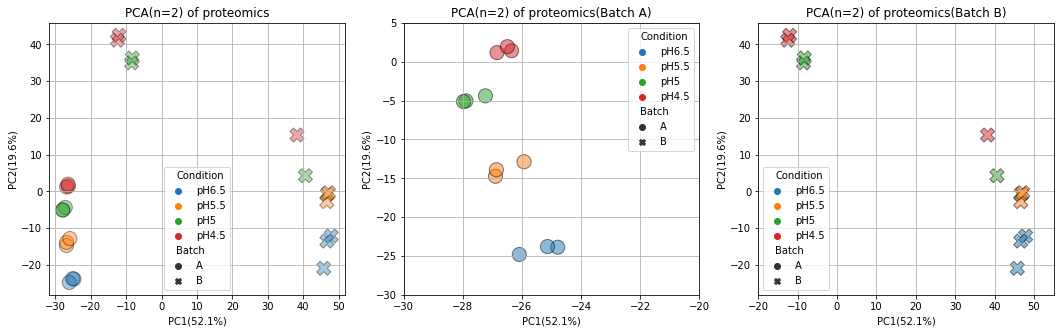

In [8]:
fig, axs = plt.subplots(1,3,figsize=(18,5))
sns.scatterplot(data=X_pca_pd, x="PC1(52.1%)", y="PC2(19.6%)", hue="Condition", style="Batch",\
                s=200,linewidth=1,alpha=0.4, edgecolor='black',ax= axs[0] )
sns.scatterplot(data=X_pca_pd, x="PC1(52.1%)", y="PC2(19.6%)", hue="Condition", style="Batch",\
                s=200,linewidth=1,alpha=0.5, edgecolor='black',ax= axs[1] )
sns.scatterplot(data=X_pca_pd, x="PC1(52.1%)", y="PC2(19.6%)", hue="Condition", style="Batch",\
                s=200,linewidth=1,alpha=0.5, edgecolor='black',ax= axs[2] )
axs[1].set_ylim([-30,5])
axs[1].set_xlim([-30,-20])
axs[2].set_xlim([-20,55])
axs[0].set_title('PCA(n=2) of proteomics')
axs[1].set_title('PCA(n=2) of proteomics(Batch A)')
axs[2].set_title('PCA(n=2) of proteomics(Batch B)')
for ax in axs:
    ax.grid()